In [223]:
import torch 
import torchvision
import torchvision.transforms as transforms 
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import sys

In [199]:
#collect original dataset 
gtsrb_train_set = torchvision.datasets.GTSRB(root='./data', split = "train", 
                                           transform = transforms.Compose([transforms.ToTensor(),
                                                           transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))]), 
                                           download = True)

In [200]:
#log image heights and widths so we can resize based on the mean measurements 
heights = []
widths = []
for img, label in gtsrb_train_set: 
  heights.append(img.size(dim=1))
  widths.append(img.size(dim=2))

In [201]:
heights_bar = [0]*max(heights)
widths_bar = [0]*max(widths)

In [202]:
for i in range(len(widths_bar)):
  widths_bar[i] = widths.count(i)

for j in range(len(heights_bar)):
  heights_bar[j] = heights.count(j)

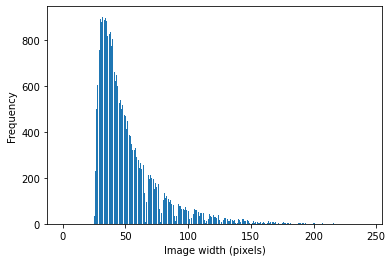

32


In [203]:
#plot bar chart of image widths 
x_widths = []
for i in range(len(widths_bar)):
  x_widths.append(i)

plt.bar(x_widths, widths_bar)
plt.xlabel("Image width (pixels)")
plt.ylabel("Frequency")
plt.show()
print(widths_bar.index(max(widths_bar)))

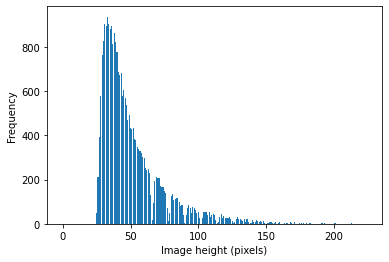

938
32


In [204]:
#plot bar chart of image heights 
x_heights = []
for i in range(len(heights_bar)):
  x_heights.append(i)
plt.bar(x_heights, heights_bar)
plt.xlabel("Image height (pixels)")
plt.ylabel("Frequency")
plt.show()
print(max(heights_bar))
print(widths_bar.index(max(widths_bar)))

In [205]:
#log number of instances in set per class 
sign_classes = []
for img, label in gtsrb_train_set: 
  sign_classes.append(label)

In [206]:
num_classes = max(sign_classes)
classes_bar = [0]*num_classes 
print(num_classes)
print(min(sign_classes))
for label_class in range(len(classes_bar)):
  classes_bar[label_class] = sign_classes.count(label_class)

42
0


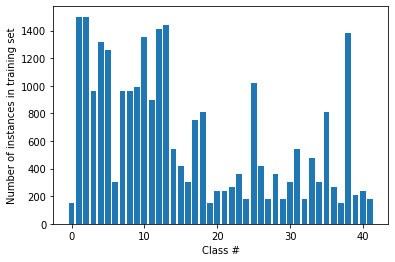

630.0
[0, 6, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41]
150


In [207]:
#plot bar chart for classes, calculate mean instances and figure out what the minority classes are 
x_classes = []
for i in range(len(classes_bar)):
  x_classes.append(i)
plt.bar(x_classes, classes_bar)
plt.xlabel("Class #")
plt.ylabel("Number of instances in training set")
plt.show()
#print(max(heights_bar))
#print(widths_bar.index(max(widths_bar)))
average_frequency = sum(classes_bar) / len(classes_bar)
print(average_frequency)
minority_classes = []
for i in range(len(classes_bar)):
  if(classes_bar[i]<average_frequency):
    minority_classes.append(i)
print(minority_classes)
print(min(classes_bar))

We want to augment data for those classes that don't meet the average number of instances of 630

In [208]:
#define custom dataset for new augmented data 
class augmentedDataset(Dataset):
    def __init__(self, img, labels):
        self.labels = labels
        self.img = img
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        labels = self.labels[idx]
        img = self.img[idx]
        return img, labels

In [210]:
#iterate over dataset to identify minority classes, create transformed versions, create an augmented datset. 
#and concatenate 
for img, label in gtsrb_train_set:
  new_tensor = torch.empty(0, dtype=torch.int64)
  new_labels = []
  if(classes_bar[label] < average_frequency):
    #create transformed list 
    #note to self--- change this so you can augment from different data within classes, this is spamming 
    # the same image again and again 
    #Response to above note-- done, but now its sampling the same image 4 times. This works well in the case that 
    #samples are extremely low, but we could leverage more data when we have n = 500 etc. 
    #Note to self #2 => leverage more data when you have time :) 
    for i in range(4):
      transformed_image = torch.nn.Sequential(transforms.ColorJitter(brightness=0.5, contrast= 1, saturation = 0.25, hue = (-0.1,0.1)), 
                                                transforms.RandomHorizontalFlip(p=0.5), 
                                                transforms.RandomVerticalFlip(p=0.05), 
                                                transforms.RandomGrayscale(p=0.02))(img)
      transformed_label = label 
      new_tensor = torch.cat((new_tensor, transformed_image),0)
      new_labels.append(label)
      classes_bar[label]+=1 
      if(classes_bar[label] >= average_frequency):
        break 
    dataset_temp = augmentedDataset(new_tensor, new_labels)
    gtsrb_train_set = torch.utils.data.ConcatDataset([gtsrb_train_set, dataset_temp])
    if(classes_bar[label]>=average_frequency):
      minority_classes.remove(label)
    if(not minority_classes):
      break 

In [226]:
augmented_classes = []
sys.setrecursionlimit(5000)
for img, label in gtsrb_train_set:
  augmented_classes.append(label)

In [227]:
num_classes_aug = max(augmented_classes)
classes_bar_aug = [0]*num_classes_aug
for label_class_aug in range(len(classes_bar_aug)):
  classes_bar_aug[label_class_aug] = augmented_classes.count(label_class_aug)

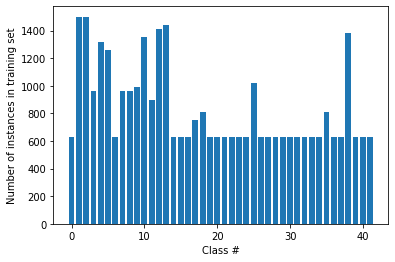

In [228]:
num_num = []
for i in range(len(classes_bar_aug)):
  num_num.append(i)
plt.bar(num_num, classes_bar_aug)
plt.xlabel("Class #")
plt.ylabel("Number of instances in training set")
plt.show()